In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime

%env SPARK_LOCAL_HOSTNAME=localhost
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *

env: SPARK_LOCAL_HOSTNAME=localhost


In [2]:
# importieren mit Schema
spark = SparkSession.builder.appName("TaxiData").getOrCreate()

schema = StructType([
    StructField("date", StringType()),
    StructField("lat", DoubleType()),
    StructField("lon", DoubleType()),
    StructField("base", StringType())
])

csv = spark.read.option("header", "true").csv("./data/uber/*.csv", schema = schema)

In [6]:
# benutzdefinierte Funktion, die richtiges Datumsformat aus erster Spalte generiert
f = udf(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S"), TimestampType())

# Anwenden der benutzerdefinierte Funktion
data = csv.withColumn("date", f(csv.date)).cache()

In [7]:
data.show()

+-------------------+-------+--------+------+
|               date|    lat|     lon|  base|
+-------------------+-------+--------+------+
|2014-08-01 00:03:00|40.7366|-73.9906|B02512|
|2014-08-01 00:09:00| 40.726|-73.9918|B02512|
|2014-08-01 00:12:00|40.7209|-74.0507|B02512|
|2014-08-01 00:12:00|40.7387|-73.9856|B02512|
|2014-08-01 00:12:00|40.7323|-74.0077|B02512|
|2014-08-01 00:13:00|40.7349|-74.0033|B02512|
|2014-08-01 00:15:00|40.7279|-73.9542|B02512|
|2014-08-01 00:17:00| 40.721|-73.9937|B02512|
|2014-08-01 00:19:00|40.7195| -74.006|B02512|
|2014-08-01 00:20:00|40.7448|-73.9799|B02512|
|2014-08-01 00:21:00|40.7399|-74.0057|B02512|
|2014-08-01 00:25:00|40.7651|-73.9683|B02512|
|2014-08-01 00:27:00|40.7354|-74.0081|B02512|
|2014-08-01 00:29:00|40.7339|-74.0028|B02512|
|2014-08-01 00:29:00|40.7364|-74.0301|B02512|
|2014-08-01 00:29:00|40.7364|-74.0301|B02512|
|2014-08-01 00:30:00|40.7252|-73.9516|B02512|
|2014-08-01 00:30:00|40.7433| -73.986|B02512|
|2014-08-01 00:34:00|40.7437|-73.9

In [8]:
data.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)



In [5]:
# das sind die Eckpunkte eines imaginären Rechtecks, 
# das das Gebiet um Manhattan einschließt

# 40.66704, -73.83396
# 40.90366, -74.10665

In [6]:
dataFiltered = data\
    .where(data.lat > 40.66704)\
    .where(data.lat < 40.90366)\
    .where(data.lon < -73.83396)\
    .where(data.lon > -74.10665)\
    .cache()

In [7]:
# Anzeige wieviel Dateneinträge vorhanden
print(data.count())
print(dataFiltered.count())

4534327
4236494


## Bilder zeichnen
- Bilder sind nur eine Zusammenfassung von Pixeln in Zeilen mit einem zugeordneten Farbwert
- **`.imshow()`** Funktion nutzt diese Logik

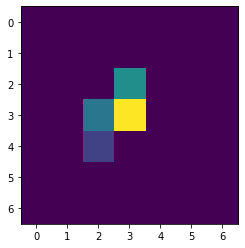

In [8]:
# jeder Eintrag repräsentiert ein Pixel
# je höher die Zahl, umso heller die Farbe
rawImage = [
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 126, 0, 0, 0],
    [0, 0, 100, 255, 0, 0, 0],
    [0, 0, 50, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]
]

plt.imshow(rawImage)
plt.show()

In [9]:
# Bezogen auf die Geokoordinaten:
# oben links: 40.90366, -74.10665
# unten rechts: 40.66704, -73.83396


# 40.90366, -74.10665 => ist auf der rawImage Position [0][0]
# 40.66704, -73.83396 => ist auf der rawImage Position [6][6]
# 40.80000, -73.95000 => ist auf der rawImage Position [3][3]

### Ziel: Geokordinaten auf Pixel transformieren

In [10]:
# Pixeltransformation erklärt

# Value ist ein Wert irgendwo zwischen den Randpunkten
value = 40.80000

# Value 2 ist ein Wert, der prozentual die Lage zwischen den Randpunkten angibt
# (Value - unterer Randwert) = Strecke Value vom Rand
# unterer Randwert - oberer Randwert: Gesamtstrecke
value2 = (value - 40.66704) / (40.90366 - 40.66704)

# Auf ein Bild von 7x7 Pixel bezogen:
# prozentualer Wert mit Gesamtstreckenlänge multipliziert
# ergibt die Lage im Raster 7x7
print(round(value2 * 7))

4


In [11]:
# Pixeltransformation angewandt auf Datensatz

import pyspark.sql.functions as F # importiert round() Funktion für Spark
size = 7
dataFiltered\
    .select(
        F.round(((dataFiltered.lat - 40.66704) / (40.90366 - 40.66704) * size)),
        F.round(((dataFiltered.lon + 73.83396) / (-74.10665 + 73.83396) * size))
    )\
    .show()

+--------------------------------------------------------+--------------------------------------------------------+
|round((((lat - 40.66704) / 0.23662000000000205) * 7), 0)|round((((lon + 73.83396) / -0.2726899999999972) * 7), 0)|
+--------------------------------------------------------+--------------------------------------------------------+
|                                                     2.0|                                                     4.0|
|                                                     2.0|                                                     4.0|
|                                                     2.0|                                                     6.0|
|                                                     2.0|                                                     4.0|
|                                                     2.0|                                                     4.0|
|                                                     2.0|              

In [12]:
# Pixeltransformation mit umbenannten Spalten
# gleiche Einträge werden gruppiert und gezählt
# Ergebnis ist die Anzahl von Fahrten bezogen auf die Pixelposition

size = 7
dataFiltered\
    .select(
        F.round(((dataFiltered.lat - 40.66704) / (40.90366 - 40.66704) * size)),
        F.round(((dataFiltered.lon + 73.83396) / (-74.10665 + 73.83396) * size))
    )\
    .withColumnRenamed("round((((lat - 40.66704) / 0.23662000000000205) * 7), 0)", "lat")\
    .withColumnRenamed("round((((lon + 73.83396) / -0.2726899999999972) * 7), 0)", "lon")\
    .groupBy("lat", "lon")\
    .count()\
    .show()

+---+---+-----+
|lat|lon|count|
+---+---+-----+
|2.0|0.0| 7583|
|7.0|3.0|  323|
|6.0|1.0| 4969|
|4.0|6.0| 1026|
|3.0|5.0| 6350|
|7.0|7.0|   17|
|0.0|5.0| 9927|
|6.0|7.0|   64|
|5.0|1.0| 2629|
|5.0|2.0| 9261|
|5.0|4.0|  601|
|6.0|3.0| 2436|
|1.0|1.0| 2603|
|7.0|1.0|  519|
|3.0|2.0|32466|
|4.0|5.0|  750|
|4.0|2.0| 5065|
|6.0|5.0|  180|
|1.0|6.0|  930|
|0.0|1.0| 1565|
+---+---+-----+
only showing top 20 rows



In [13]:
# Pixeldaten generieren
###

# size verändert die Pixelanzahl
# taucht in der Spaltenüberschrift durch select()-FUnktion wieder auf
# in select muss size auch dynamisch geändert werden: str(size)
size = 1000

# Lade alle Pixeldaten in Pythonobjekt
dataForImage = dataFiltered\
    .select(
        F.round(((dataFiltered.lat - 40.66704) / (40.90366 - 40.66704)) * size),
        F.round(((dataFiltered.lon + 73.83396) / (-74.10665 + 73.83396)) * size)
    )\
    .withColumnRenamed(
        "round((((lat - 40.66704) / 0.23662000000000205) * " + str(size) + "), 0)", 
        "lat"
    )\
    .withColumnRenamed(
        "round((((lon + 73.83396) / -0.2726899999999972) * " + str(size) + "), 0)", 
        "lon"
    )\
    .groupBy("lat", "lon")\
    .count()\
    .collect()

In [14]:
print(dataForImage)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



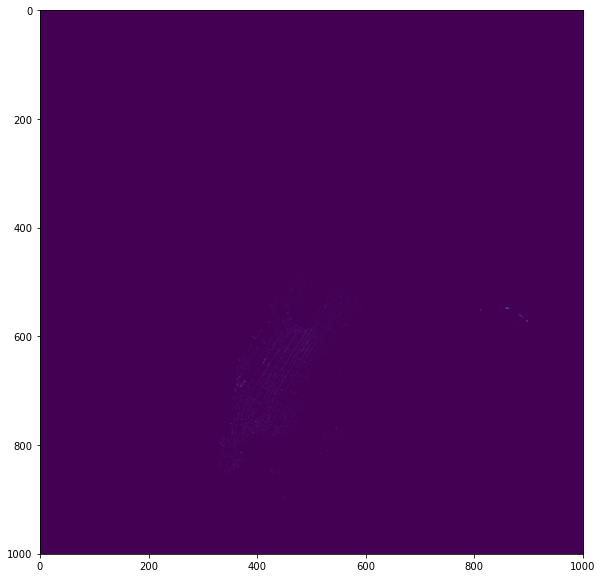

In [15]:
# Bild mit Pixelwerten = Fahrtenzahl
###

# Image Array
img = []
# fülle mein Image Array mit 0
for i in range(0, size + 1):
    imgRow = []
    for j in range(0, size + 1):
        imgRow.append(0)
    img.append(imgRow)
    
# fülle das Image Array mit den Counts
for row in dataForImage:
    img[size - int(row.lat)][size - int(row.lon)] = row["count"]

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

### Problem: Bild zu dunkel
- reine Counts als Pixelwert macht nur die Bereiche hell, wo viele Fahrten stattfinden
- Unterschied zwischen wenigen und vielen Fahrten muss reduziert werden

**Lösung: Logarithmus reduziert große Zahlen**

In [16]:
import math


In [17]:
math.log(2)

0.6931471805599453

In [18]:
math.log(20)

2.995732273553991

In [19]:
math.log(40)

3.6888794541139363

fertig

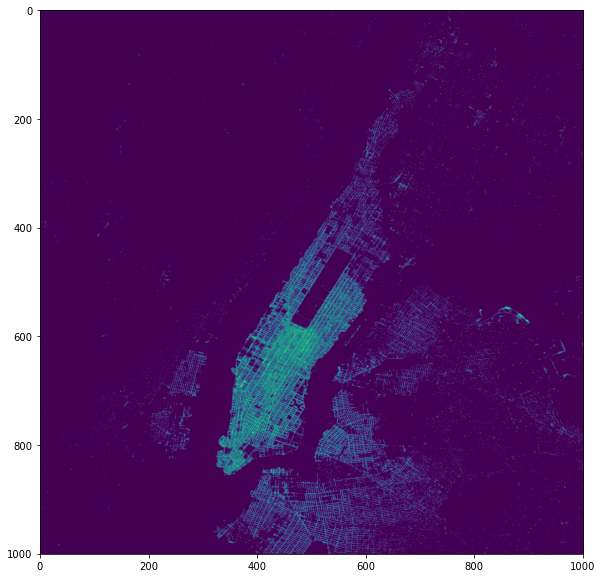

In [20]:
# Bild mit Pixelwerten = logarithmierte Fahrtenzahl
###

%matplotlib inline
import matplotlib.pyplot as plt

img = []
for i in range(0, size + 1):
    imgRow = []
    for j in range(0, size + 1):
        imgRow.append(0)
    img.append(imgRow)
    
for row in dataForImage:
    img[size - int(row.lat)][size - int(row.lon)] = math.log(row["count"])

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()